In [2]:
!pip install -qU transformers
!pip install -qU datasets
!pip install -qU seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:

!pip install evaluate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json

# Import classes and functions from Hugging Face's Transformers library
from transformers import AutoTokenizer, BertForTokenClassification
import torch  # Import PyTorch libraries for tensor operations and data handling
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split, Dataset
from torch.nn.functional import pad   # Padding function for tensors
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from tqdm.auto import tqdm    # Automatic tqdm selection based on environment
from evaluate import load
metric = load("seqeval")   # Load seqeval for NER evaluation

# Suppress warnings to keep output clean
import warnings
warnings.filterwarnings(action="ignore")  # Ignore all warnings

pd.set_option('display.max_colwidth', 3000)  # Set max column width to 3000
pd.set_option('display.max_columns', None)   # Display all DataFrame columns

# Determine the computation device: use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


device(type='cpu')

In [4]:
CYELGREENBG = '\033[43m'
CFUKSIABG = '\033[45m'
CLBLUEBG = '\033[46m'
CGREYBG    = '\33[100m'
CREDBG    = '\33[101m'
CGREENBG  = '\33[102m'
CYELLOWBG = '\33[103m'
CBLUEBG   = '\33[104m'
CVIOLETBG = '\33[105m'
CBEIGEBG  = '\33[106m'
CEND  = '\33[107m'

color_mapping = {'O': CEND, 'GEO': CYELLOWBG, 'GPE': CREDBG, 'PER': CBLUEBG, 'ORG':CVIOLETBG,
                 'TIM': CBEIGEBG, 'ART': CYELGREENBG, 'NAT': CFUKSIABG, 'EVE':CLBLUEBG
                 }

In [7]:
df = pd.read_csv("NER dataset.csv", encoding='unicode_escape')
df.rename(columns={"Sentence #": "Sentence"}, inplace=True)

df["Tag"] = df["Tag"].apply(lambda x: x.upper())
df["TagGeneral"] = df["Tag"].apply(lambda x: x.split("-")[-1])
df["TagPos"] = df["Tag"].apply(lambda x: x.split("-")[0])
df["Word"].fillna("None", inplace=True)

df

,Sentence,Word,POS,Tag,TagGeneral,TagPos
0,Sentence: 1,Thousands,NNS,O,O,O
1,NaN,of,IN,O,O,O
2,NaN,demonstrators,NNS,O,O,O
3,NaN,have,VBP,O,O,O
4,NaN,marched,VBN,O,O,O
...,...,...,...,...,...,...
1048570,NaN,they,PRP,O,O,O
1048571,NaN,responded,VBD,O,O,O
1048572,NaN,to,TO,O,O,O
1048573,NaN,the,DT,O,O,O


In [8]:
tag_list = df["Tag"].unique()
tag_general_list = df["TagGeneral"].unique()

n_tags = len(tag_list)
n_tag_general = len(tag_general_list)

tags2ids = {tag: i for i, tag in enumerate(tag_list)}
ids2tags = {i: tag for i, tag in enumerate(tag_list)}

df["TagId"] = df["Tag"].map(tags2ids)
df

,Sentence,Word,POS,Tag,TagGeneral,TagPos,TagId
0,Sentence: 1,Thousands,NNS,O,O,O,0
1,NaN,of,IN,O,O,O,0
2,NaN,demonstrators,NNS,O,O,O,0
3,NaN,have,VBP,O,O,O,0
4,NaN,marched,VBN,O,O,O,0
...,...,...,...,...,...,...,...
1048570,NaN,they,PRP,O,O,O,0
1048571,NaN,responded,VBD,O,O,O,0
1048572,NaN,to,TO,O,O,O,0
1048573,NaN,the,DT,O,O,O,0


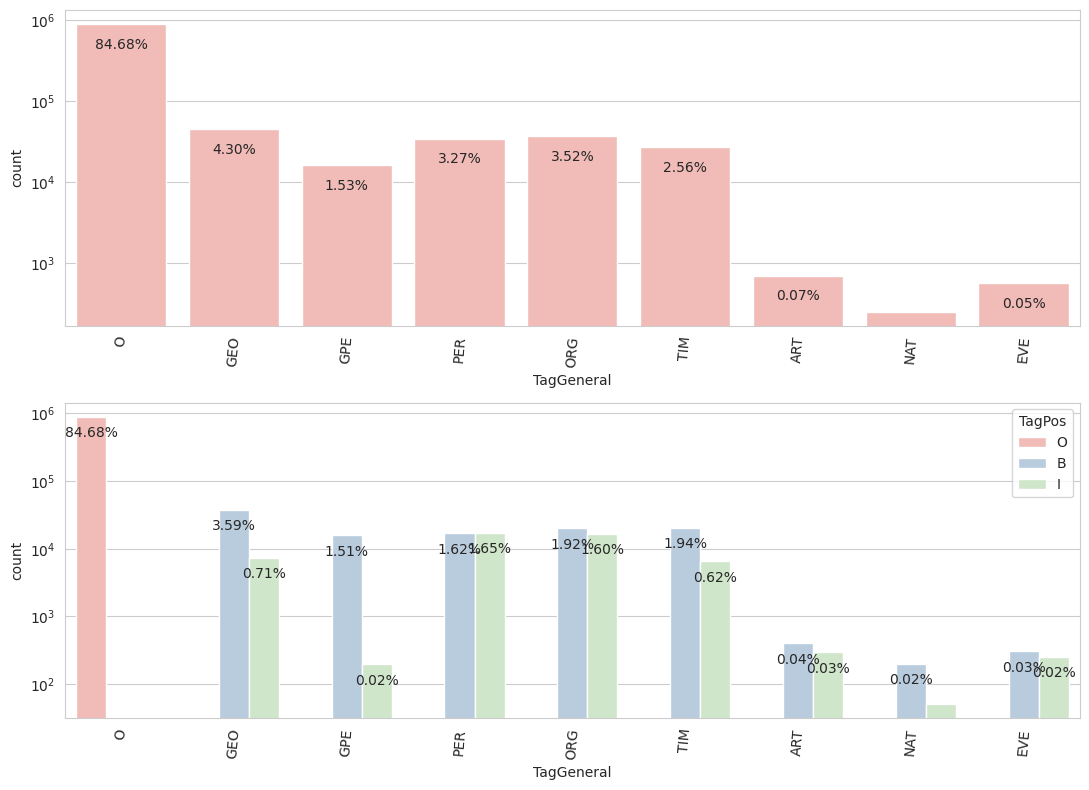

In [9]:
sns.set_palette(palette="Pastel1")
sns.set_style("whitegrid")

fig, axs =plt.subplots(2,1, figsize=(11,8))
sns.countplot(x=df['TagGeneral'], ax=axs[0])
sns.countplot(x=df['TagGeneral'], ax=axs[1], hue =df["TagPos"])
axs[0].tick_params(axis='x', rotation=85)
axs[1].tick_params(axis='x', rotation=85)

total = len(df)
for ax in axs:
    ax.set_yscale("log")
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()/2
        ax.annotate(percentage, (x, y), ha='center', fontsize=10, rotation=0)
fig.tight_layout()
fig.show()

In [10]:
df["Sentence"] = df["Sentence"].fillna(method='ffill')
df = df.groupby("Sentence").agg(list).reset_index().drop("Sentence", axis=1)
print(f"Number of records: {len(df)}")
df.head(5)

Number of records: 47959


,Word,POS,Tag,TagGeneral,TagPos,TagId
0,"[Thousands, of, demonstrators, have, marched, through, London, to, protest, the, war, in, Iraq, and, demand, the, withdrawal, of, British, troops, from, that, country, .]","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, NN, IN, NNP, CC, VB, DT, NN, IN, JJ, NNS, IN, DT, NN, .]","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GPE, O, O, O, O, O]","[O, O, O, O, O, O, GEO, O, O, O, O, O, GEO, O, O, O, O, O, GPE, O, O, O, O, O]","[O, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]"
1,"[Iranian, officials, say, they, expect, to, get, access, to, sealed, sensitive, parts, of, the, plant, Wednesday, ,, after, an, IAEA, surveillance, system, begins, functioning, .]","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, JJ, NNS, IN, DT, NN, NNP, ,, IN, DT, NNP, NN, NN, VBZ, VBG, .]","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TIM, O, O, O, B-ORG, O, O, O, O, O]","[GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, TIM, O, O, O, ORG, O, O, O, O, O]","[B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, B, O, O, O, O, O]","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 5, 0, 0, 0, 0, 0]"
2,"[Helicopter, gunships, Saturday, pounded, militant, hideouts, in, the, Orakzai, tribal, region, ,, where, many, Taliban, militants, are, believed, to, have, fled, to, avoid, an, earlier, military, offensive, in, nearby, South, Waziristan, .]","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, NN, ,, WRB, JJ, NNP, NNS, VBP, VBN, TO, VB, VBN, TO, VB, DT, JJR, JJ, NN, IN, JJ, NNP, NNP, .]","[O, O, B-TIM, O, O, O, O, O, B-GEO, O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO, O]","[O, O, TIM, O, O, O, O, O, GEO, O, O, O, O, O, ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, GEO, GEO, O]","[O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, I, O]","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0]"
3,"[They, left, after, a, tense, hour-long, standoff, with, riot, police, .]","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[U.N., relief, coordinator, Jan, Egeland, said, Sunday, ,, U.S., ,, Indonesian, and, Australian, military, helicopters, are, ferrying, out, food, and, supplies, to, remote, areas, of, western, Aceh, province, that, ground, crews, can, not, reach, .]","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, JJ, CC, JJ, JJ, NNS, VBP, VBG, RP, NN, CC, NNS, TO, VB, NNS, IN, JJ, NNP, NN, IN, NN, NNS, MD, RB, VB, .]","[B-GEO, O, O, B-PER, I-PER, O, B-TIM, O, B-GEO, O, B-GPE, O, B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O, O, O, O, O, O, O]","[GEO, O, O, PER, PER, O, TIM, O, GEO, O, GPE, O, GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, GEO, O, O, O, O, O, O, O, O]","[B, O, O, B, I, O, B, O, B, O, B, O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, O, O]","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [11]:
def display_formatted_text(words, tags):
    formatted_text = " ".join([color_mapping[tag] + word for word, tag in zip(words, tags)]) + CEND
    print(formatted_text)

text = df.loc[0, "Word"]
tags = df.loc[0, "TagGeneral"]
display_formatted_text(text, tags)

text = df.loc[42, "Word"]
tags = df.loc[42, "TagGeneral"]
display_formatted_text(text, tags)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
The U.S. rap star Snoop Dogg and five of his associates have been arrested in Britain after a disturbance at London 's Heathrow Airport .


In [12]:
huggingface_model = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(huggingface_model, do_lower_case=True)
tokenizer.special_tokens_map

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [13]:
model = BertForTokenClassification.from_pretrained(
    huggingface_model,
    num_labels = n_tags,
    output_attentions = False,
    output_hidden_states = False,
).to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs = df["Word"].values
        self.labels =df["TagId"].values
        self.len = len(self.labels)

    def __getitem__(self, idx):
        encoded_dict = tokenizer(self.inputs[idx],
                                 is_split_into_words=True,
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )
        token_labels = self.__create_token_labels(self.labels[idx], encoded_dict.word_ids())
        return encoded_dict['input_ids'][0], encoded_dict['token_type_ids'][0], encoded_dict['attention_mask'][0], token_labels

    def __create_token_labels(self, labels, word_ids ):
        extended_labels = [-100 if word_id is None else labels[word_id] for word_id in word_ids]
        return torch.tensor(extended_labels).to(torch.int64)

    def __len__(self):
        return self.len

In [15]:

def collate_fn(batch):
    max_len = max([len(sample[0]) for sample in batch])

    ids = []
    token_types = []
    attention_masks = []
    labels = []

    for sample in batch:
        pad_length = max_len - len(sample[0])
        ids.append(pad(sample[0], (0, pad_length), value=0))
        token_types.append(pad(sample[1], (0, pad_length), value=0))
        attention_masks.append(pad(sample[2], (0, pad_length), value=0))
        labels.append(pad(sample[3], (0, pad_length), value=-100))

    return torch.stack(ids).to(device), torch.stack(token_types).to(device), torch.stack(attention_masks).to(device), torch.stack(labels).to(device)

In [16]:
dataset = CustomDataset(df, tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset)  - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))

38,367 training samples
9,592 validation samples


In [22]:
batch_size = 8

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

In [23]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

In [ ]:
EPOCHS = 2
avg_train_accuracy = []
avg_train_loss = []
avg_val_loss = []
avg_val_accuracy = []

for epoch_i in range(EPOCHS):

    running_train_loss = 0
    running_val_loss = 0

    model.train()

    loop = tqdm(train_dataloader)

    for batch in loop:

        optimizer.zero_grad()
        output = model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])

        loss = output.loss
        running_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        loop.set_description(f"Training. Epoch [{epoch_i}/{EPOCHS}]. Loss {loss.item()}")

    avg_train_loss.append(running_train_loss / len(train_dataloader))


    model.eval()
    with torch.no_grad():
        loop = tqdm(validation_dataloader)
        for batch in loop:
            output = model(input_ids=batch[0],
                           token_type_ids=batch[1],
                           attention_mask=batch[2],
                           labels=batch[3])
            loss = output.loss
            running_val_loss += loss.item()
            loop.set_description(f"Validation. Epoch [{epoch_i}/{EPOCHS}]. Loss {loss.item()}")
    avg_val_loss.append(running_val_loss / len(validation_dataloader))

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(11, 5), sharex=True, sharey=True)

axs[0].plot(avg_train_loss)
axs[0].set_title("Average training loss")

axs[1].plot(avg_val_loss)
axs[1].set_title("Average validation loss")

axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

for row in axs:
     ax.grid(c='gray', alpha=0.5)

In [17]:
!pip install evaluate

In [ ]:
# Evaluation Code

from tqdm.auto import tqdm

def evaluate(model, dataloader, ids2tags, metric, device):
    """
    Evaluates the model on the given dataloader and computes metrics.

    Args:
        model: The trained BERT model for token classification.
        dataloader: DataLoader for the validation dataset.
        ids2tags: Dictionary mapping label IDs to tag names.
        metric: Evaluation metric (e.g., seqeval).
        device: Device to perform computation on ('cuda' or 'cpu').

    Returns:
        Dictionary containing evaluation metrics.
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids, token_type_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask
            )

        logits = outputs.logits  # Shape: (batch_size, seq_len, num_labels)
        predictions = torch.argmax(logits, dim=2)  # Shape: (batch_size, seq_len)

        # Convert tensors to numpy arrays
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()

        # Iterate over each sentence in the batch
        for pred, label in zip(predictions, labels):
            pred_tags = []
            true_tags = []

            for p, l in zip(pred, label):
                if l != -100:  # Ignore tokens with label -100
                    pred_tags.append(ids2tags.get(p, "O"))  # Default to "O" if not found
                    true_tags.append(ids2tags.get(l, "O"))

            all_predictions.append(pred_tags)
            all_labels.append(true_tags)

    # Compute metrics
    results = metric.compute(predictions=all_predictions, references=all_labels)
    return results

# After your training loop, add the evaluation code

# Ensure the model is on the correct device
model.to(device)

# Call the evaluate function
evaluation_results = evaluate(model, validation_dataloader, ids2tags, metric, device)

# Print the evaluation results
print("Evaluation Results:")
print(f"Precision: {evaluation_results['overall_precision']:.4f}")
print(f"Recall: {evaluation_results['overall_recall']:.4f}")
print(f"F1-Score: {evaluation_results['overall_f1']:.4f}")
print(f"Accuracy: {evaluation_results['overall_accuracy']:.4f}")

# Optionally, display more detailed metrics
# For example, per-entity type metrics
print("\nDetailed Metrics:")
for key, value in evaluation_results.items():
    if key.startswith("overall"):
        continue  # Already printed overall metrics
    print(f"{key}: {value}")


## **Chatbot code**

In [25]:
pip install torch transformers


In [40]:
import torch
from transformers import AutoTokenizer, BertForTokenClassification, AutoModelForCausalLM, pipeline

# Force device to CPU since CUDA is unavailable
device = torch.device('cpu')

# Initialize NER model and tokenizer
huggingface_model = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer_ner = AutoTokenizer.from_pretrained(huggingface_model)
model_ner = BertForTokenClassification.from_pretrained(huggingface_model).to(device)

# Initialize Conversational model and tokenizer (DialoGPT for this example)
conversational_model = "microsoft/DialoGPT-small"
tokenizer_conv = AutoTokenizer.from_pretrained(conversational_model)
model_conv = AutoModelForCausalLM.from_pretrained(conversational_model).to(device)

# Use pre-built NER pipeline
ner = pipeline("ner", model=huggingface_model, aggregation_strategy="simple")

# Function to extract named entities from the user input
def extract_entities(raw_text):
    entities = ner(raw_text)
    return [(entity['word'], entity['entity_group']) for entity in entities]

# Map entity abbreviations to full terms
entity_map = {
    'LOC': 'location',
    'PER': 'person',
    'ORG': 'organization',
    'GPE': 'geopolitical entity',
    'TIM': 'time',
    'ART': 'artwork',
    'NAT': 'nationality or religion',
    'EVE': 'event',
    'MISC': 'miscellaneous',
    'O': 'other'
}

# Enhanced response function
def generate_response(user_input, chat_history_ids):
    entities = extract_entities(user_input)
    if entities:
        # Format recognized entities for response
        formatted_entities = ", ".join([f"{entity[0]} (recognized as a {entity_map.get(entity[1], entity[1])})" for entity in entities])
        return f"Recognized entities: {formatted_entities}", chat_history_ids
    else:
        return "Not entities recognized.", chat_history_ids

# The main conversational chatbot
def conversational_chatbot():
    print("Welcome to the Conversational Chatbot! Type 'exit' to quit.")

    chat_history_ids = None  # Keeps track of chat history
    while True:
        user_input = input("You: ")

        if user_input.lower() == "exit":
            print("Goodbye!")
            break

        # Generate conversational response
        bot_response, chat_history_ids = generate_response(user_input, chat_history_ids)
        print(f"Bot: {bot_response}")



Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trai

In [41]:
# Start the chatbot
if __name__ == "__main__":
    conversational_chatbot()


Welcome to the Conversational Chatbot! Type 'exit' to quit.
You: Paris is a city
Bot: Recognized entities: Paris (recognized as a location)
You: I work at a company called Paris
Bot: Recognized entities: Paris (recognized as a organization)
You: My name is Paris
Bot: Recognized entities: Paris (recognized as a person)
You: I dodged a bullet
Bot: Not entities recognized.
You: I work at a Dodge dealership
Bot: Recognized entities: Dodge (recognized as a organization)
You: My name is Lincoln and drive a lincoln
Bot: Recognized entities: Lincoln (recognized as a person)
You: My name is Lincoln and drive a Lincoln
Bot: Recognized entities: Lincoln (recognized as a person), Lincoln (recognized as a organization)
You: exit
Goodbye!
